<div class="usecase-title">UC00161_Apply_predictive_learning_for_On_street_parking_availability_along_with_restrictions</div>

<div class="usecase-authors"><b>Authored by:</b> Emmanuel Clement Anthony </div>

<div class="usecase-duration"><b>Duration:</b> {90} mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>{Intermediate}</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>{Python}</div>
</div>

<div class="usecase-section-header">Scenario</div>

As a commuter or city traffic planner,
I want to predict the availability of on-street parking while considering local parking restrictions,
So that I can either find parking more efficiently or monitor parking compliance for smarter enforcement.

<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Access and use open data from the City of Melbourne API

- Merge datasets based on spatial and rule-based identifiers

- Perform time-aware feature engineering

- Determine whether parking is allowed at a given time and location

- Identify likely parking violations

- Visualize time-based parking trends using Python

- Prepare your dataset for exploratory data analysis (EDA) and modeling

<div class="usecase-section-header">Background</div>

In densely populated cities like Melbourne, on-street parking availability is a daily challenge for residents, visitors, and delivery services. Drivers often waste time and fuel circling around blocks searching for open parking spots, which contributes to traffic congestion, air pollution, and driver frustration.

The City of Melbourne provides open datasets including real-time parking bay sensor data and information about parking restrictions posted on sign plates. By combining these datasets, we can develop a smarter system to predict parking availability while considering time-based restrictions such as loading zones, permit-only areas, and limited parking durations (e.g., 1P, 2P).

This use case uses data sourced directly from Melbourne's Open Data API:

On-Street Parking Bay Sensors: Provides real-time occupancy status and location of parking bays.

Sign Plates Located in Each Parking Zone: Details the permitted parking days, hours, and restriction types.

By integrating and analyzing this data, we aim to create a model that not only predicts where parking is likely available but also whether it's legally permitted at that time — enabling smarter planning and enforcement.


# Importing Libraries

In [42]:
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN
import numpy as np

# Import Data via City of Melbourne API

In [2]:
def API_Unlimited(datasetname, apikey): 
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    format = 'csv'

    url = f'{base_url}{datasetname}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': apikey
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        df = pd.read_csv(StringIO(url_content), delimiter=';')
        print(df.sample(10, random_state=999))
        return df
    else:
        print(f'Request failed with status code {response.status_code}')
        return None

apikey = ''
# Dataset IDs from Melbourne Open Data portal
datasets = {
    'parking_sensors': 'on-street-parking-bay-sensors',
    'sign_plates': 'sign-plates-located-in-each-parking-zone'
}

# Load datasets
parking_sensors_df = API_Unlimited(datasets['parking_sensors'], apikey)
sign_plates_df = API_Unlimited(datasets['sign_plates'], apikey)

                    lastupdated           status_timestamp  zone_number  \
1427  2025-04-05T05:38:36+00:00  2025-02-07T00:58:43+00:00       7923.0   
325   2025-04-05T05:38:36+00:00  2025-04-05T05:25:10+00:00       7621.0   
1559  2025-04-05T05:38:36+00:00  2025-04-05T04:50:42+00:00       7586.0   
84    2024-12-04T23:44:37+00:00  2024-11-28T01:15:59+00:00       7084.0   
857   2025-04-05T05:38:36+00:00  2025-04-05T04:54:18+00:00       7247.0   
863   2025-04-05T05:38:36+00:00  2025-03-20T22:09:50+00:00       7258.0   
1643  2025-04-05T05:38:36+00:00  2024-12-25T00:19:24+00:00       7202.0   
2982  2025-04-05T05:38:36+00:00  2025-04-05T04:36:32+00:00       7167.0   
369   2025-04-05T05:38:36+00:00  2025-04-05T03:57:09+00:00       7753.0   
3279  2025-04-05T05:38:36+00:00  2025-03-24T01:35:08+00:00       7577.0   

     status_description  kerbsideid                                 location  
1427            Present       10845  -37.806642456045324, 144.95501315634544  
325             

# Preprocessing Data


In [3]:
# Convert timestamp column to datetime format
parking_sensors_df['lastupdated'] = pd.to_datetime(parking_sensors_df['lastupdated'], errors='coerce')

# Extract hour and weekday from the timestamp
parking_sensors_df['hour'] = parking_sensors_df['lastupdated'].dt.hour
parking_sensors_df['weekday'] = parking_sensors_df['lastupdated'].dt.day_name()

# Ensure zone_number columns match data types for merging
parking_sensors_df['zone_number'] = parking_sensors_df['zone_number'].astype('Int64')
sign_plates_df['parkingzone'] = sign_plates_df['parkingzone'].astype('Int64')


## Merge Datasets on Zone Number

In [4]:
merged_df = pd.merge(parking_sensors_df, sign_plates_df, 
                     how='left', 
                     left_on='zone_number', 
                     right_on='parkingzone')

print(f"{merged_df['restriction_display'].notna().sum()} out of {len(merged_df)} rows matched with restriction data")


7797 out of 8036 rows matched with restriction data


At this stage, I merged the real-time parking sensor data with the restriction signage dataset using the zone_number column. This allowed me to enrich each sensor record with the corresponding legal parking rules.

Out of 8036 records, 7797 were successfully matched, which means I achieved a 97.03% match rate. This gives me a strong base to continue analysing parking behaviour and identifying violations with high confidence.

## Convert Time Restrictions

In [5]:
# Convert time strings to proper datetime.time format
merged_df['time_restrictions_start'] = pd.to_datetime(
    merged_df['time_restrictions_start'], format='%H:%M:%S', errors='coerce'
).dt.time

merged_df['time_restrictions_finish'] = pd.to_datetime(
    merged_df['time_restrictions_finish'], format='%H:%M:%S', errors='coerce'
).dt.time


## Create is_parking_allowed_now Flag

In [27]:
# Function to determine if parking is allowed
def is_parking_allowed_now(row):
    try:
        # Ensure no missing values
        if pd.isna(row['hour']) or pd.isna(row['weekday']) or pd.isna(row['time_restrictions_start']) or pd.isna(row['time_restrictions_finish']):
            return None

        current_time = datetime.time(int(row['hour']))
        current_day = row['weekday'].strip().lower()
        allowed_days = str(row['restriction_days']).strip().lower()
        start = row['time_restrictions_start']
        end = row['time_restrictions_finish']

        # Map full weekday name to abbreviation
        day_map = {
            'monday': 'mon', 'tuesday': 'tue', 'wednesday': 'wed',
            'thursday': 'thu', 'friday': 'fri', 'saturday': 'sat', 'sunday': 'sun'
        }
        day_abbr = day_map.get(current_day)

        # Build list of valid days based on pattern
        if allowed_days in ['mon-sun', 'daily']:
            valid_days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
        elif allowed_days == 'mon-fri':
            valid_days = ['mon', 'tue', 'wed', 'thu', 'fri']
        elif allowed_days == 'sat-sun':
            valid_days = ['sat', 'sun']
        else:
            # Support comma-separated custom values like "mon,wed,fri"
            valid_days = [d.strip() for d in allowed_days.split(',')]

        if day_abbr not in valid_days:
            return False

        # Handle overnight restriction (e.g. 22:00 to 06:00)
        if start > end:
            return current_time >= start or current_time <= end
        else:
            return start <= current_time <= end

    except:
        return None

I wrote a function to check whether a vehicle is allowed to park at the time a sensor reading was taken. It considers both:

The day of the week (e.g. Mon–Fri, Sat–Sun)

The time of day (including overnight cases like 10PM–6AM)

If the current timestamp falls outside the allowed window for that day, the function returns False. This will help me later identify cases where someone was parked illegally.

## Preview Final Data

In [33]:
print(merged_df[['lastupdated', 'hour', 'weekday', 'restriction_days', 
                 'time_restrictions_start', 'time_restrictions_finish', 
                 'is_parking_allowed_now']].head())


                lastupdated  hour  weekday restriction_days  \
0 2025-01-21 03:42:37+00:00     3  Tuesday          Mon-Sun   
1 2025-01-21 03:42:37+00:00     3  Tuesday          Mon-Sun   
2 2025-01-21 03:42:37+00:00     3  Tuesday          Mon-Sun   
3 2025-01-21 03:42:37+00:00     3  Tuesday          Mon-Sun   
4 2025-01-21 03:42:37+00:00     3  Tuesday          Mon-Sun   

  time_restrictions_start time_restrictions_finish is_parking_allowed_now  
0                07:30:00                 23:00:00                  False  
1                07:30:00                 23:00:00                  False  
2                07:30:00                 23:00:00                  False  
3                07:30:00                 23:00:00                  False  
4                07:30:00                 23:00:00                  False  


At this point, I previewed the final enriched dataset to check whether my logic for identifying legal parking times is working correctly.

In this specific sample, all the sensor records were captured at 3:42 AM on a Tuesday, and each one belongs to a zone with a restriction listed as "Mon-Sun, 07:30:00 to 23:00:00".

Since the reading occurred before 7:30 AM, my function correctly marked the is_parking_allowed_now flag as False — meaning parking is not allowed at that time.

This confirms that the time-based filtering is working as intended, including the handling of day ranges like "Mon-Sun" and time windows.

# Exploratory Data Analysis

Now that I’ve engineered key features like time, weekday, and parking restriction logic, I’m ready to explore patterns in the data.

In this section, I begin by visualising violations across different time dimensions — starting with day of the week and hour of the day — to uncover trends that might be useful for prediction or policy-making.


### Create is_violation Column

In [34]:
# Create a new column indicating parking violations
merged_df['is_violation'] = merged_df.apply(
    lambda row: True if row['status_description'] == 'Present' and row['is_parking_allowed_now'] == False else False,
    axis=1
)

# Preview
print(merged_df[['status_description', 'is_parking_allowed_now', 'is_violation']].head())


  status_description is_parking_allowed_now  is_violation
0         Unoccupied                  False         False
1         Unoccupied                  False         False
2            Present                  False          True
3            Present                  False          True
4         Unoccupied                  False         False


Now that I have a reliable flag for whether parking is allowed at a specific time, I created a new column called is_violation.

This column checks two conditions:

The parking sensor status is 'Present' (i.e., a vehicle is detected).

Parking is not allowed at that time, according to the restriction rules.

If both conditions are met, I flag it as a parking violation (True). Otherwise, it’s marked as False.

In the preview above, rows where no vehicle is detected ('Unoccupied') are correctly marked as not violations. However, in rows where the sensor detects a vehicle during restricted hours, the violation is flagged — this confirms my logic is working as expected.

### Visualize Violations by Weekday and Hour:

### Violations by Weekday

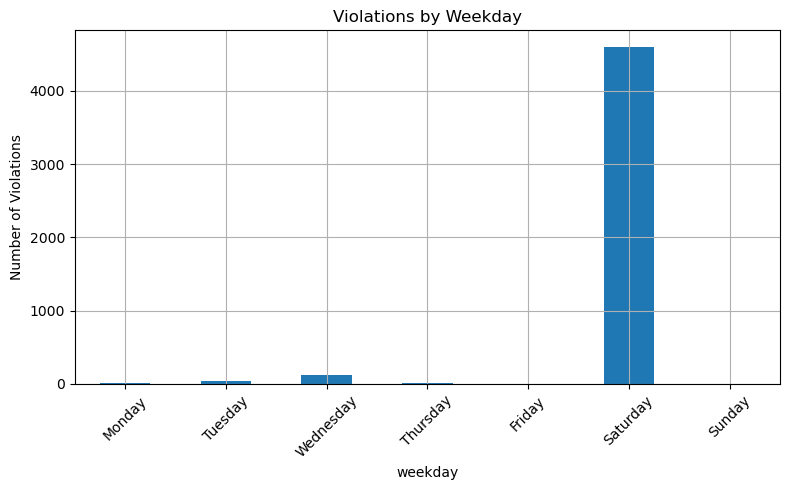

In [30]:
# Count violations by weekday
weekday_violations = merged_df.groupby('weekday')['is_violation'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot
plt.figure(figsize=(8, 5))
weekday_violations.plot(kind='bar')
plt.title("Violations by Weekday")
plt.ylabel("Number of Violations")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


To better understand when parking violations are happening, I grouped the data by weekday and summed the number of violations for each day.

From the bar plot above, it's clear that Saturday stands out with a significantly higher number of violations compared to other weekdays. This could be due to:

- Stricter or longer parking restrictions in effect on weekends

- Higher demand for parking in commercial or entertainment areas

- Lower awareness or attention to signage on weekends

This insight can help traffic planners target enforcement more effectively or investigate why Saturday generates so many infractions.

### Violations by Hour



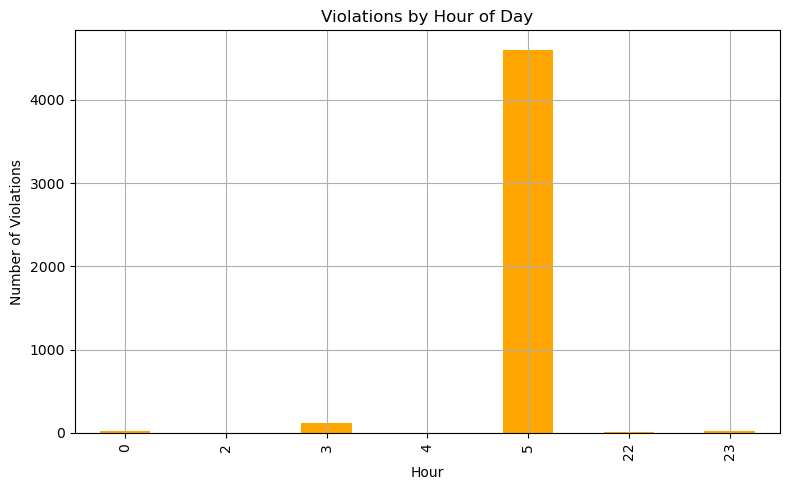

In [31]:
# Count violations by hour
hour_violations = merged_df.groupby('hour')['is_violation'].sum()

# Plot
plt.figure(figsize=(8, 5))
hour_violations.plot(kind='bar', color='orange')
plt.title("Violations by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Violations")
plt.grid(True)
plt.tight_layout()
plt.show()


After exploring violations by weekday, I wanted to understand what time of day most violations were occurring. To do this, I grouped violations by the hour column and plotted the results.

The visualisation shows a sharp spike in violations at 5 AM, with smaller clusters around 3 AM, 0 (midnight), and 23 (11 PM). This pattern could be caused by:

- Overnight parking restrictions ending early in the morning

- Vehicles staying parked after a cutoff time like 5:00 AM

- Lack of awareness of time-based signage during overnight hours

This insight can be very useful for scheduling parking enforcement patrols during high-risk hours — particularly in the early morning.

### Violation Rate by Parking Zone

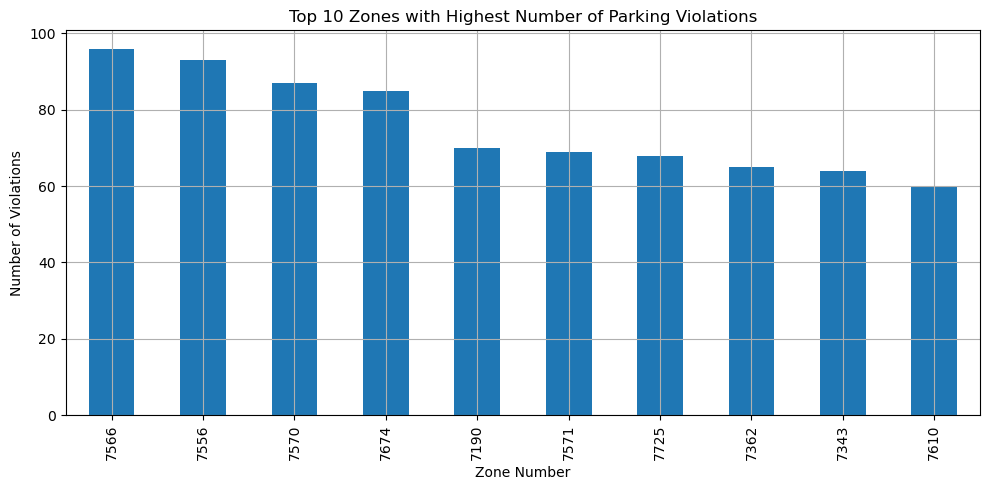

In [35]:
# Top 10 zones with the most violations
zone_violations = merged_df.groupby('zone_number')['is_violation'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
zone_violations.plot(kind='bar')
plt.title("Top 10 Zones with Highest Number of Parking Violations")
plt.xlabel("Zone Number")
plt.ylabel("Number of Violations")
plt.grid(True)
plt.tight_layout()
plt.show()



To identify which areas are hotspots for illegal parking, I grouped the data by `zone_number` and calculated the total number of violations in each zone.

The bar chart above shows the top 10 zones with the highest number of violations. These zones may represent:

- High-demand parking areas (e.g., near shopping precincts or offices)
- Places where signage is unclear or commonly overlooked
- Locations that could benefit from more frequent monitoring or clearer rules

This insight is useful for both city enforcement planning and for training future predictive models that consider zone-based risk.

### Violation Count by Restriction Type

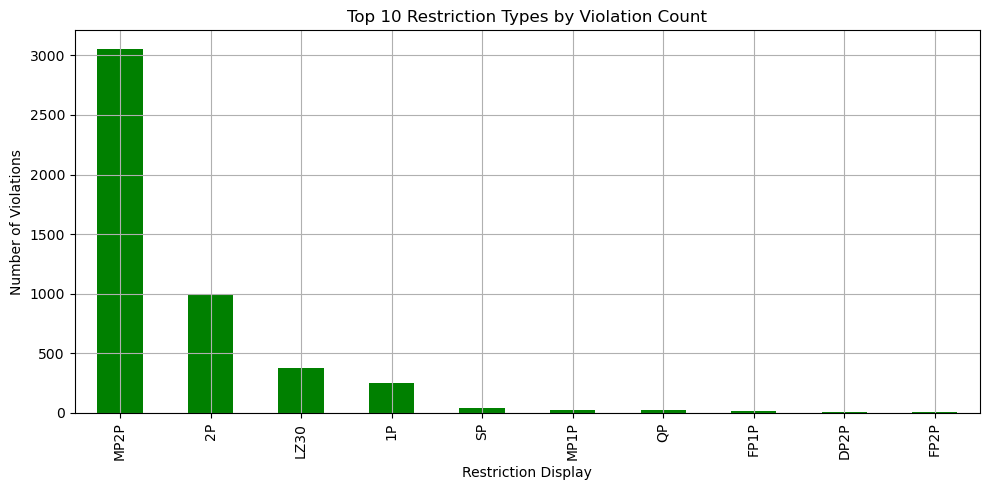

In [36]:
# Violation counts by restriction type
restriction_violations = merged_df.groupby('restriction_display')['is_violation'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
restriction_violations.plot(kind='bar', color='green')
plt.title("Top 10 Restriction Types by Violation Count")
plt.xlabel("Restriction Display")
plt.ylabel("Number of Violations")
plt.grid(True)
plt.tight_layout()
plt.show()


To understand which parking rules are most frequently broken, I grouped violations by the `restriction_display` field — which represents the signage drivers see (like 1P, 2P, or loading zones).

From the bar chart above, it’s clear that **MP2P** and **2P** zones have the highest number of violations by a large margin. This could be due to:

- Short time limits (like 2P = 2 hours) often being exceeded
- High turnover zones where enforcement is stricter
- Confusion about multi-purpose or permit signage in MP zones

By identifying which restrictions are most prone to violation, I can help inform better signage design, targeted enforcement, or future prediction models that take restriction type into account.

### Heatmap – Violations by Hour × Weekday

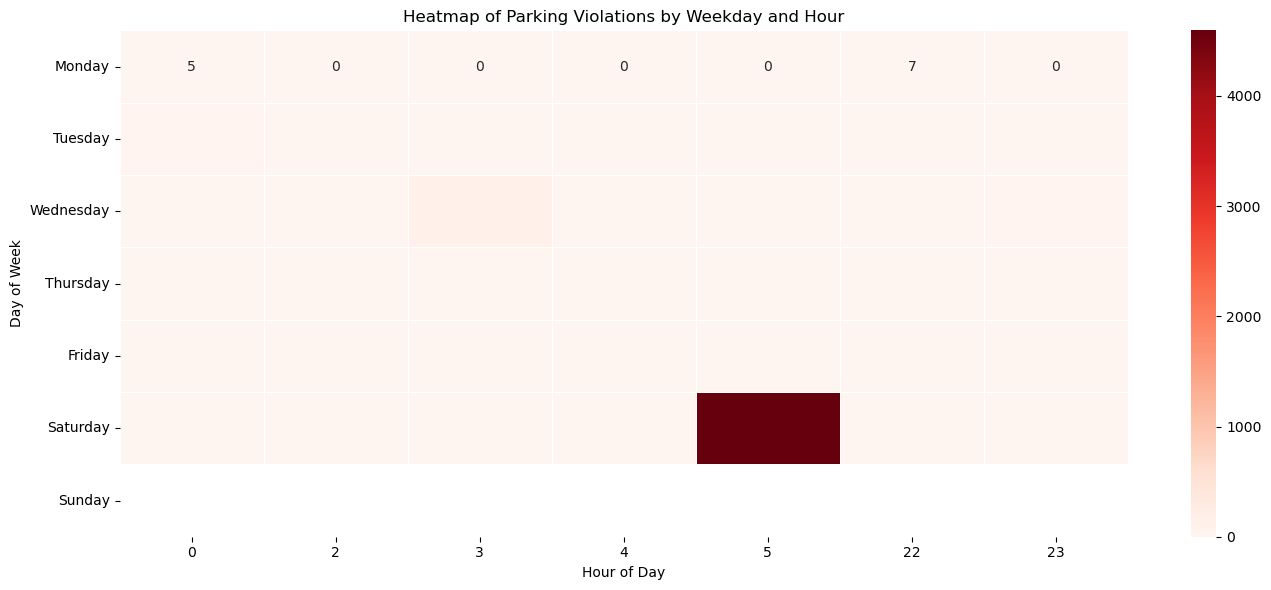

In [38]:
heatmap_data = merged_df.pivot_table(
    index='weekday', columns='hour', values='is_violation', aggfunc='sum', fill_value=0)

# Reorder weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(weekday_order)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, annot=True, fmt='.0f')
plt.title("Heatmap of Parking Violations by Weekday and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

To explore violation patterns across both **time of day** and **day of week**, I created this heatmap using a pivot table. It shows the total number of parking violations for each hour across all weekdays.

From the heatmap, I can clearly see:
- A **huge spike on Saturdays at 5 AM**, far more than any other time.
- Minor activity during early mornings on other weekdays, especially around 12 AM and 3 AM.
- Minimal to no violations detected on Sundays and most weekdays during the day.

This confirms that violations are not evenly distributed — they tend to cluster around early weekend mornings, which is important insight for:

- **Targeted parking enforcement**
- **Model feature selection**
- **Understanding user behaviour in high-risk time windows**